# Goals

Build a model to predict conversion rate and come up with a way to improve revenue 

In [124]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [29]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [35]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

In [45]:
import seaborn as sns

In [125]:
PATH = Path('data/conversion_data.csv')

In [126]:
df = pd.read_csv(PATH)

In [9]:
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [10]:
df.dtypes

country                object
age                     int64
new_user                int64
source                 object
total_pages_visited     int64
converted               int64
dtype: object

In [11]:
df.isnull().sum(axis=0)

country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
converted              0
dtype: int64

# Single feature exploration/preprocess

## country

CategoricalDtype(categories=['China', 'Germany', 'UK', 'US'], ordered=False)

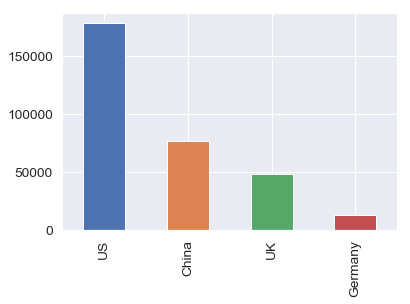

In [127]:

df.country = df.country.astype('category')
df.country.dtypes
df.country.value_counts().plot(kind='bar')

Text(0.5,1,'Conversion rate = 1')

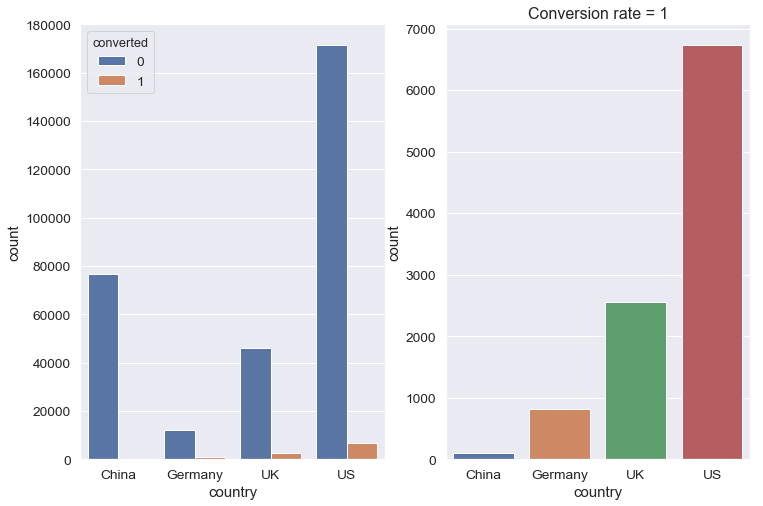

In [145]:
f,axes = plt.subplots(1,2,figsize=(12,8),sharex=True)
sns.countplot(x='country',hue='converted',data=df,ax=axes[0])
sns.countplot(x='country',data=df[df.converted==1],ax=axes[1])
axes[1].set_title('Conversion rate = 1', fontsize=16)

China and Germany seems to have low conversion rate

## Age

count    316200.000000
mean         30.569858
std           8.271802
min          17.000000
25%          24.000000
50%          30.000000
75%          36.000000
max         123.000000
Name: age, dtype: float64

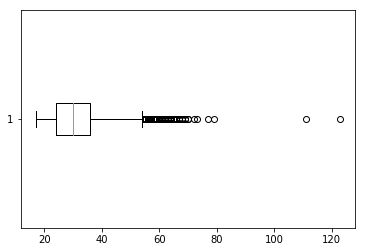

In [69]:

_=plt.boxplot(df.age,vert=False)
df.age.describe()

In [128]:
# get outliers
# iqr = df.age.quantile(q=0.75) - df.age.quantile(q=0.25)
# lower = df.age.quantile(q=0.25) - iqr*1.5
# upper = df.age.quantile(q=0.75) + iqr*1.5
# lower,upper

(6.0, 54.0)

In [130]:
df[df.age>=80]
# Interesting to see these 2 users are converted. Class label 'converted' is highly imbalanced.

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


In [131]:
df.drop(df[df.age>=80].index,inplace=True)

C:\Users\qtran\AppData\Local\Continuum\Miniconda3\envs\fastai-cpu\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


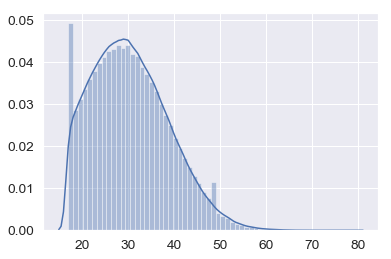

In [132]:
sns.distplot(df.age.values,bins=60,kde=True)

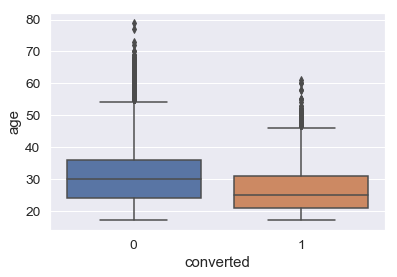

In [146]:
sns.boxplot(x='converted',y='age',data=df)

## new_user

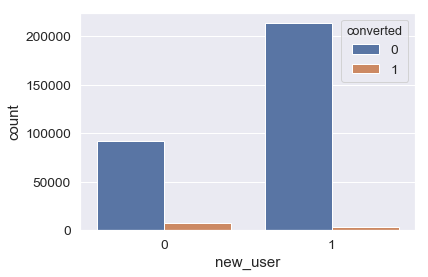

In [149]:
sns.countplot(x='new_user',hue='converted',data=df)
# df.new_user.value_counts().plot(kind='bar')

## source

Text(0.5,1,'Conversion rate = 1')

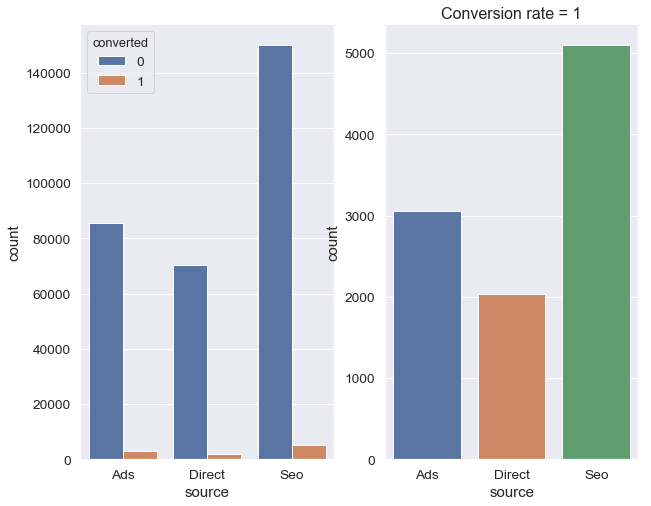

In [152]:
df.source = df.source.astype('category')
f,axes = plt.subplots(1,2,figsize=(10,8),sharex=True)
sns.countplot(x='source',hue='converted',data=df,ax=axes[0])
sns.countplot(x='source',data=df[df.converted==1],ax=axes[1])
axes[1].set_title('Conversion rate = 1', fontsize=16)
# df.source.value_counts().plot(kind='bar')

## total page visited

count    316198.000000
mean          4.872918
std           3.341053
min           1.000000
25%           2.000000
50%           4.000000
75%           7.000000
max          29.000000
Name: total_pages_visited, dtype: float64

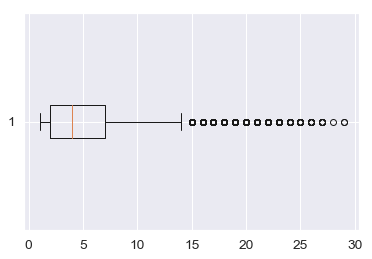

In [135]:

_=plt.boxplot(df.total_pages_visited,vert=False)
df.total_pages_visited.describe()

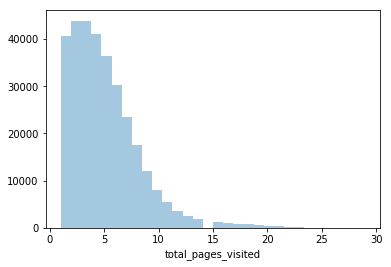

In [85]:
sns.distplot(df.total_pages_visited,bins=30,kde=False)

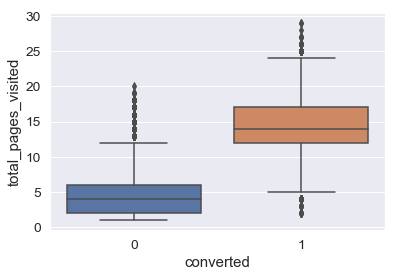

In [153]:
sns.boxplot(x='converted',y='total_pages_visited',data=df)

There is a clear division between conversion rate based on total pages visited: people are less likely to convert when they visit <=7 pages (>50% of people who dont convert), and people are more likely to convert when they visit >= 10 pages (>50% of people who convert)

# dependent var

In [89]:
y = df.converted

In [91]:
(y.value_counts() / len(y) )*100

0    96.774194
1     3.225806
Name: converted, dtype: float64

Classification problem with inbalanced class

# Multiple features exploration

Since we have only 5 independant features and only 2 of them are categorical and they are not sparse, we can apply one hot encoding and thus can see the contribution of each category better.

In [159]:
# downcast some numerical fea
cat = ['country','source']
for col in df.columns.values:
    if col not in cat: df[col]=df[col].astype(np.uint8)

In [161]:
df_dummy = pd.get_dummies(df)

In [162]:
df_dummy.dtypes

age                    uint8
new_user               uint8
total_pages_visited    uint8
converted              uint8
country_China          uint8
country_Germany        uint8
country_UK             uint8
country_US             uint8
source_Ads             uint8
source_Direct          uint8
source_Seo             uint8
dtype: object

In [163]:
corrmat = df_dummy.corr(method='pearson')
# pearson correlation

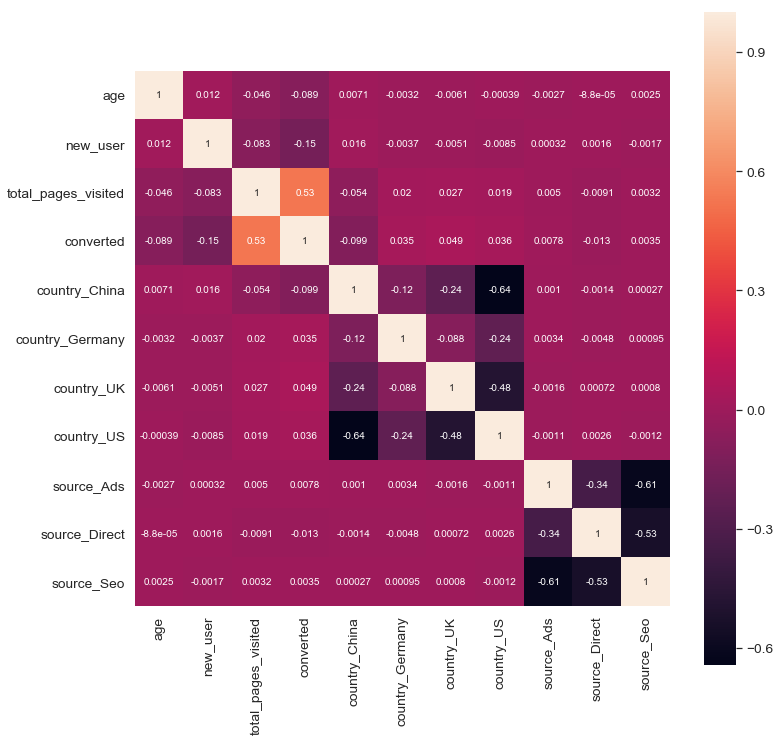

In [165]:
f,ax = plt.subplots(figsize=(12,12))
sns.heatmap(corrmat,square=True,annot=True)

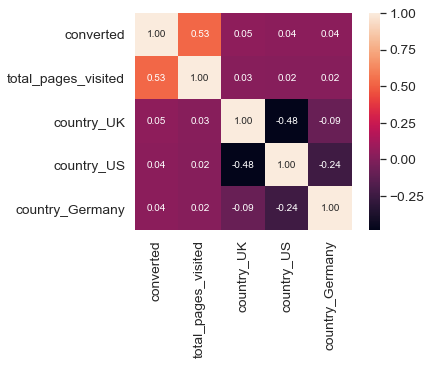

In [167]:
# top 5 features with high pearson correlation against class label 'converted'

k = 5 #number of variables for heatmap
cols = corrmat.nlargest(k, 'converted')['converted'].index
cm = np.corrcoef(df_dummy[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()


Beside total_pages_visited, no other features has > .5 correlation with class label. Dependent features don't correlate with each other, thus we have a little-to-zero multicolinear dataset

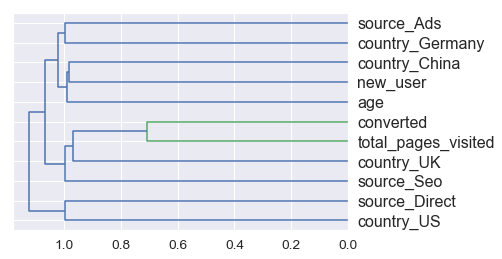

In [170]:
#another way to see feature correlation: draw dendrogram of spearman rank correlation
import scipy
from scipy.cluster import hierarchy as hc
corr = np.round(scipy.stats.spearmanr(df_dummy).correlation,4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed,method='average')
# fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z,labels = df_dummy.columns,orientation='left',leaf_font_size=16)
plt.show()

As expected, total_pages_visited and converted are the 2 highest correlated feature in this dataset (marked by green lines)

# Machine learning

Since one of the goal is to predict AND give recommendation to improve conversion rate, we can choose type of model that can produce feature importances. For this dataset, 2 models to be considered are: logistic regression and random forest (decision tree based)
- Logistic regression: simple, easy to intepret. Dataset has low level of multicollinearity. Extract feature importance from coefficient
- Random Forest: an improvement from logistic regression. More powerful, a little harder to intepret. RF can extract useful feature interaction. RF can also show feature interaction with single tree plot. Extract feature importance using permutation importance (instead of gini importance from sklearn)

# Evaluation

Since this is an imbalanced classification problem, using accuracy metric might not be a good idea as a simple baseline model of predicting non-conversion all the time can result in 96% accuracy. With imbalanced dataset, 2 suggestions for metrics are precision/recall (f-beta score to focus on more precision) and AUC (area under the curve) as there is no need to set the correct decision threshold (it's hard to do it for imbalanced dataset anyway).

